We analyse how the Koopman eigenfunctions look when only parts of the state space are explored.
We then study the discrepancies between the partially informed koopman functions and their trajectory based estimation step.

We hope to distil a heuristic on how to choose adaptively new sample points for the exploration of the phase space.

Conjecture 1: High variance in the koopman expectation indicates a transition region.
Conjecture 2: We want more samples where we have transitions (=bottlenecks) and we want samples where the current approximation is bad (we already speed up learning here by the use of mse loss (gradient proportional to residual))

In [1]:
include("sqra.jl")
using Arpack
using Plots
Matrix(v::Vector) = reshape(v, length(v), 1)

Matrix{T} where T (alias for Array{T, 2} where T)

In [2]:
include("isokann.jl");
include("neurcomm.jl")

# Basic setup with SQRA

In [3]:
dist = 1.5
dx = .02
xs = -dist:dx:dist
potential(x) = sum(@. (x^2-1)^2)

beta_to_sigma(beta) = sqrt(2/beta)
sigma_to_beta(sigma) = 2 / sigma^2
@show sigma = 0.8
@show beta = sigma_to_beta(sigma)
U  = [potential(x) for x in xs]
phi = 1/step(xs)^2 * beta
Q  = phi * sqra(Matrix(U), beta);

sigma = 0.8 = 0.8
beta = sigma_to_beta(sigma) = 3.1249999999999996


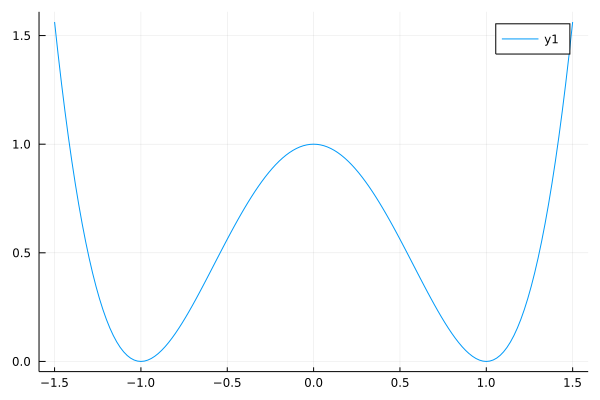

In [4]:
plot(xs, U)

niter = 47


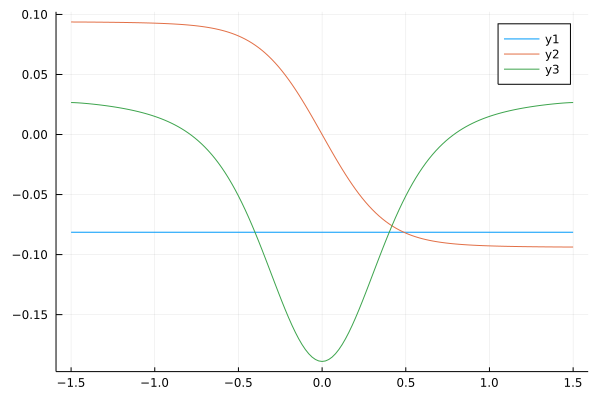

In [5]:
λ, ϕ, nconv,niter,nmult,resid = eigs(Q, which=:LR, maxiter=3000)
@show niter
plot(xs, ϕ[:,1:3] |> real)

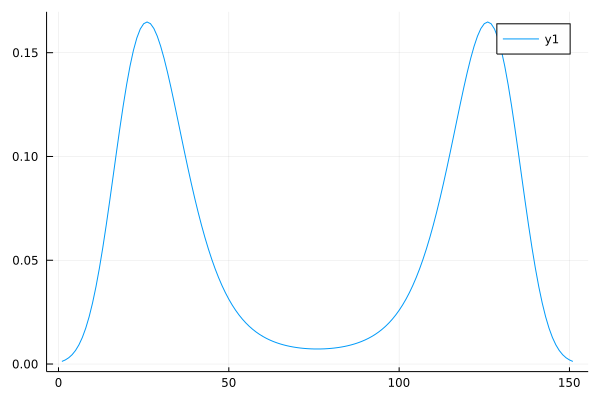

In [6]:
_, pi = eigs(Q', which=:LR)
pi = abs.(pi[:,1])
plot(real(pi))

# Restricted Koopmans

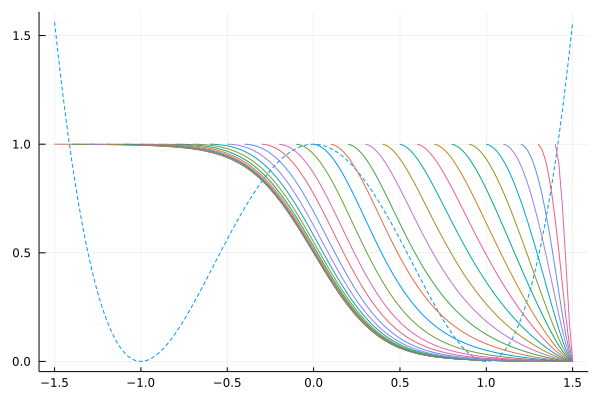

In [7]:
p=plot(xs, U, legend=false, style=:dash)
koopmans = []
koopmanxs = []
for i=1:5:size(Q,1)-3
    QQ  = sqra(Matrix(U[i:end]), beta);
    λ, ϕ, nconv,niter,nmult,resid = eigs(QQ, which=:LR, nev=3)
    χ = ϕ[:,2] |> real
    χ = χ * sign(χ[1] - χ[end])
    χ = shiftscale(χ)
    
    push!(koopmans, χ)
    push!(koopmanxs, xs[i:end])
    
    plot!(xs[i:end], χ)
end
p

In [8]:
function gridfunction(grid, values)
    grid = grid .+ step(grid) / 2
    function (x)
        x < grid[1] && return values[1]
        i = findfirst(y->y>x, grid)
        i == nothing && return values[end]
        return values[i]
    end
end

gridfunction (generic function with 1 method)

# Sampling
[] fit the timescales so that the above plots lie together (almost done, up to factor 10?!)

[] do this analysis but with partially informed koopmans, and check if we can learn something from the discrepancies

In [9]:
# we need this in some module
# maybe the argumetns should work in time not no of steps, i.e. stepsize, duration, saveintervals

function eulermarujamatrajectories(x0::Matrix, potential::Function, sigma::Real, dt::Real, steps::Integer; branches::Integer=1)
    dim, samples = size(x0)
    xts = similar(x0, dim, steps+1, branches, samples)
    for s in 1:samples
        for b in 1:branches
            x = x0[:, s]
            xts[:, 1, b, s] = x
            for t in 2:steps+1
                g = Zygote.gradient(potential, x)[1]
                x .+= -g * dt .+ sigma * randn(dim) * sqrt(dt)
                xts[:, t, b, s] = x
            end
        end
    end
    xts
end


x0 = rand(1,1) * 3 .- 1.5
trajs = eulermarujamatrajectories(x0, potential, sigma, .1, 10000, branches=1)

1×10001×1×1 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0359591  -0.0631457  -0.34339  -0.991928  …  0.660497  0.744902  0.847586

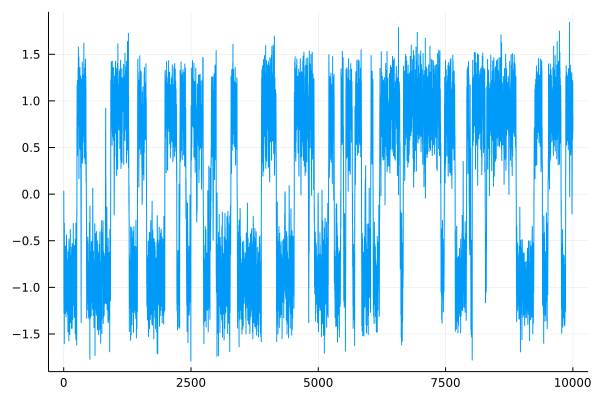

In [10]:
plot(trajs[1,:,1,1], legend=false)

In [11]:
r = 20


xsr = koopmanxs[r]
@show minimum(xsr)

x0 = reshape(collect(xsr), 1, length(xsr))

dt = 0.01
nt = 1000
branches = 300
print(dt*nt, " seconds")
kf = gridfunction(koopmanxs[r], koopmans[r])

#function koopmanexpectation(f, x0, potential, sigma, dt, nt, branches)
    trajs = eulermarujamatrajectories(x0, potential, sigma, dt, nt, branches=branches)
    k1 = mean(kf.(trajs[1,end,:,:]), dims=1) |> vec
#end

#k1 = koopmanexpectation(kf, x0, potential, sigma, 0.01, 1000, 100);

minimum(xsr) = 0.4
10.0 seconds

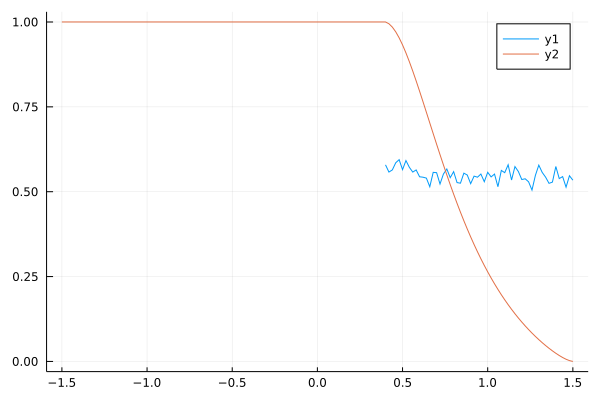

In [12]:
plot(xsr, k1) 
plot!(xs, kf)


#filled = zeros(length(xs))
#filled[end-length(xsr)+1:end] = koopmans[r]
#plot!(xs, filled)
#plot!(xs,exp(collect(Q)) * filled)

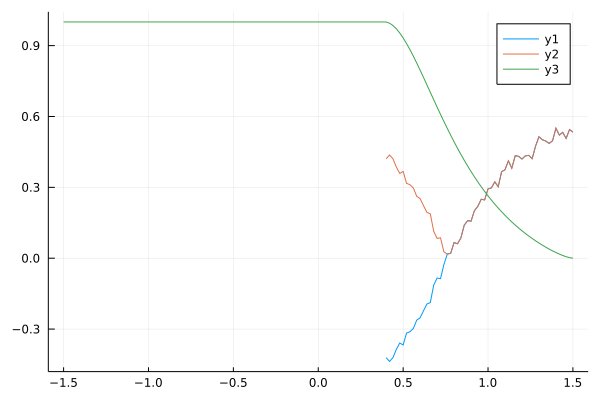

In [13]:
plot(xsr,k1 .- kf.(xsr))
plot!(xsr,k1 .- kf.(xsr) .|> abs)
plot!(xs,kf)

# we observe big discrepancies where we have not sampled yet

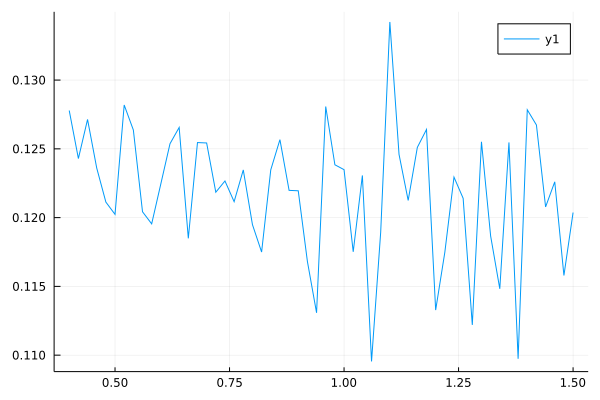

In [14]:
plot(xsr, var(kf.(trajs[1,end,:,:]), dims=1) |> vec)